In [208]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [209]:
count_df=pd.read_csv('data/8_antenna.tsv.gz', compression='gzip', sep='\t',header=None, index_col=0)
count_df.index.name=''
count_df=count_df.T.dropna()
adata = sc.AnnData(count_df)

# Quality Control

None


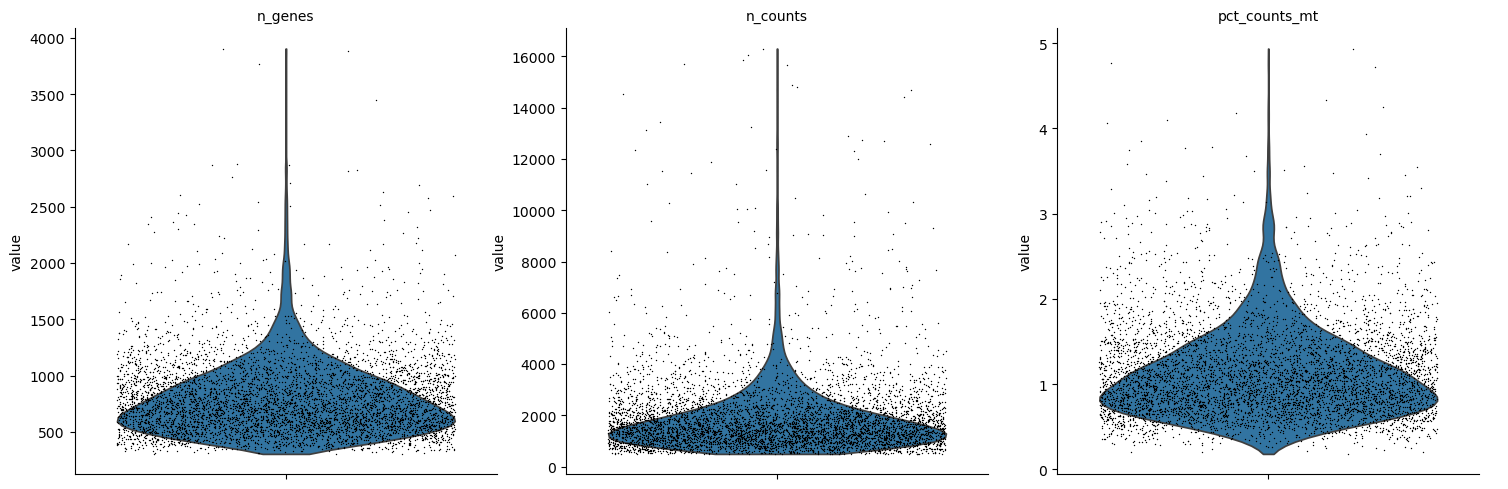

In [212]:
sc.pp.filter_cells(adata, min_genes=1)  # Adjust the threshold as needed
sc.pp.filter_cells(adata, min_counts=1)  # Adjust the threshold as needed

# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
print(sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
))
sc.pl.violin(
    adata,
    ["n_genes", "n_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

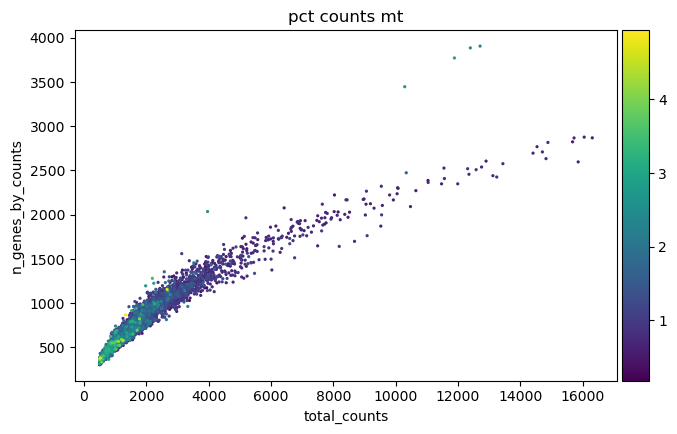

In [213]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

# Filtering

In [214]:
sc.pp.filter_cells(adata, max_counts=10000)  # Adjust the threshold as needed
sc.pp.filter_cells(adata, max_genes=3000)  # Adjust the threshold as needed

In [215]:
print("Min counts:", np.min(adata.X))
print("Max counts:", np.max(adata.X))
print("Mean counts:", np.mean(adata.X))
sc.pl.violin(
    adata,
    ["n_genes", "n_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Min counts: 0
Max counts: 494
Mean counts: 0.1534978117455739


# Normalisation

In [217]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

# Feature Selection

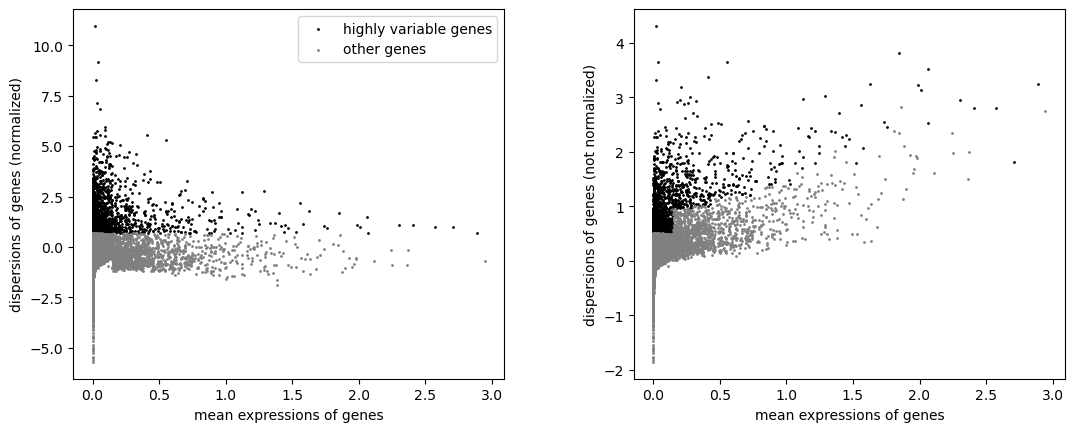

In [218]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

# Dimension Reduction

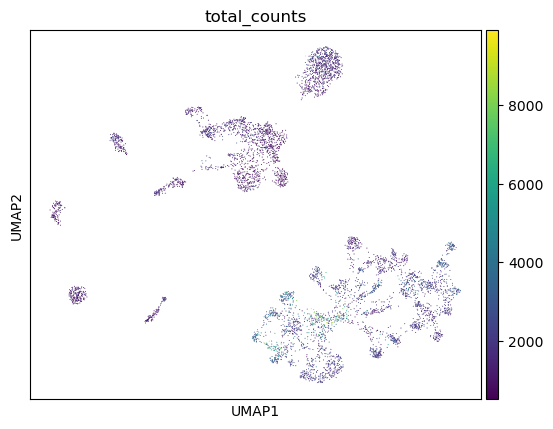

In [219]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.tsne(adata)
sc.pl.umap(
    adata,
    color="total_counts",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

# Clustering

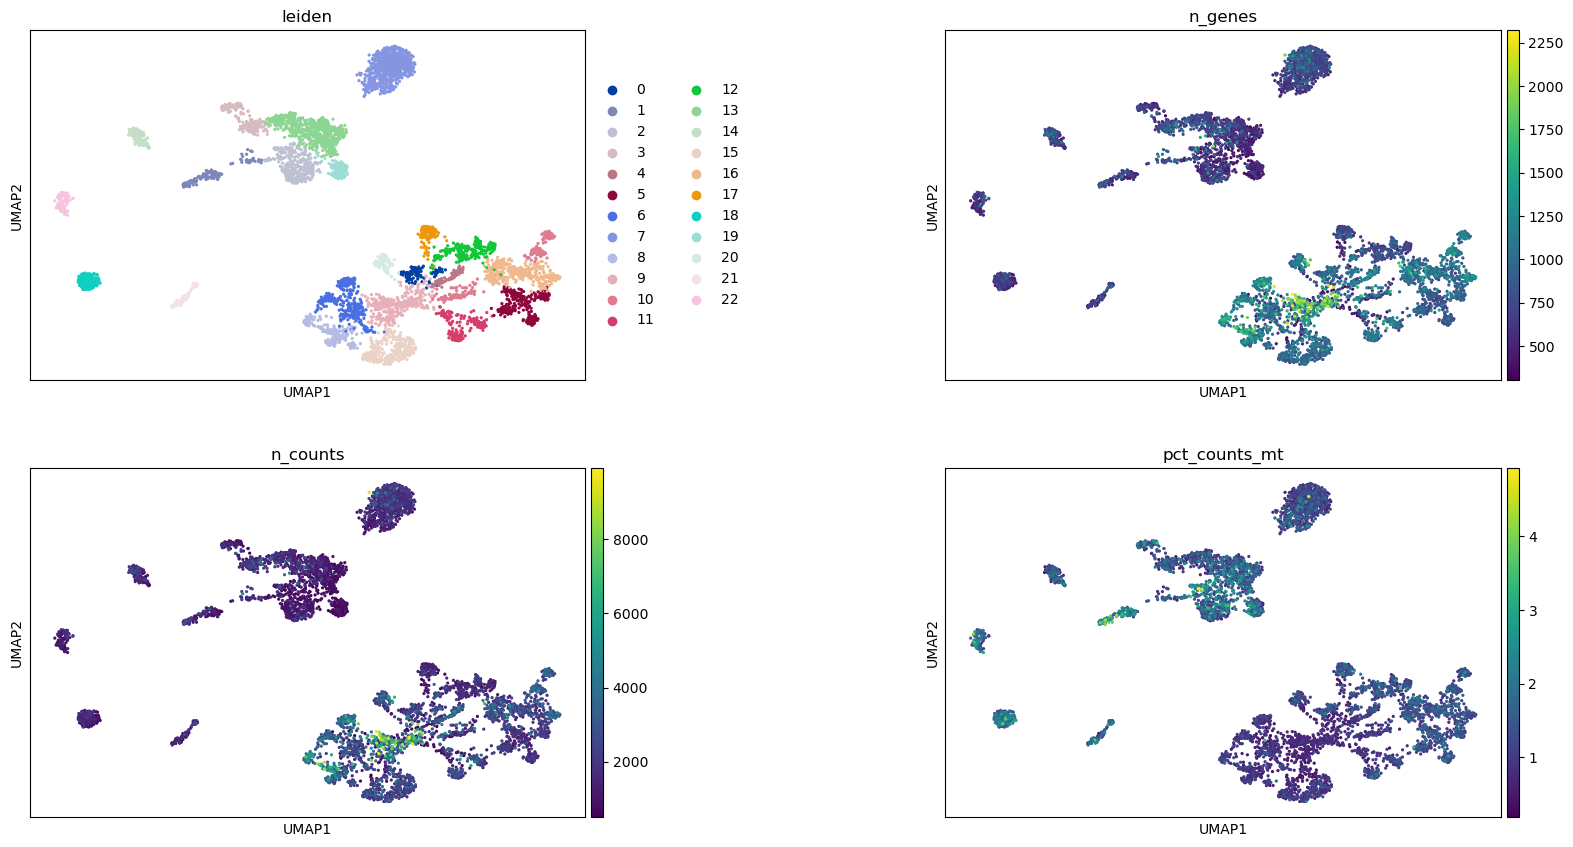

In [220]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2,resolution=1)
sc.pl.umap(
    adata,
    color=["leiden", "n_genes", "n_counts", "pct_counts_mt"],
    wspace=0.5,
    ncols=2,
)

# Marker Genes
To understand the different clusters we can get marker genes and display them in a dotplot.

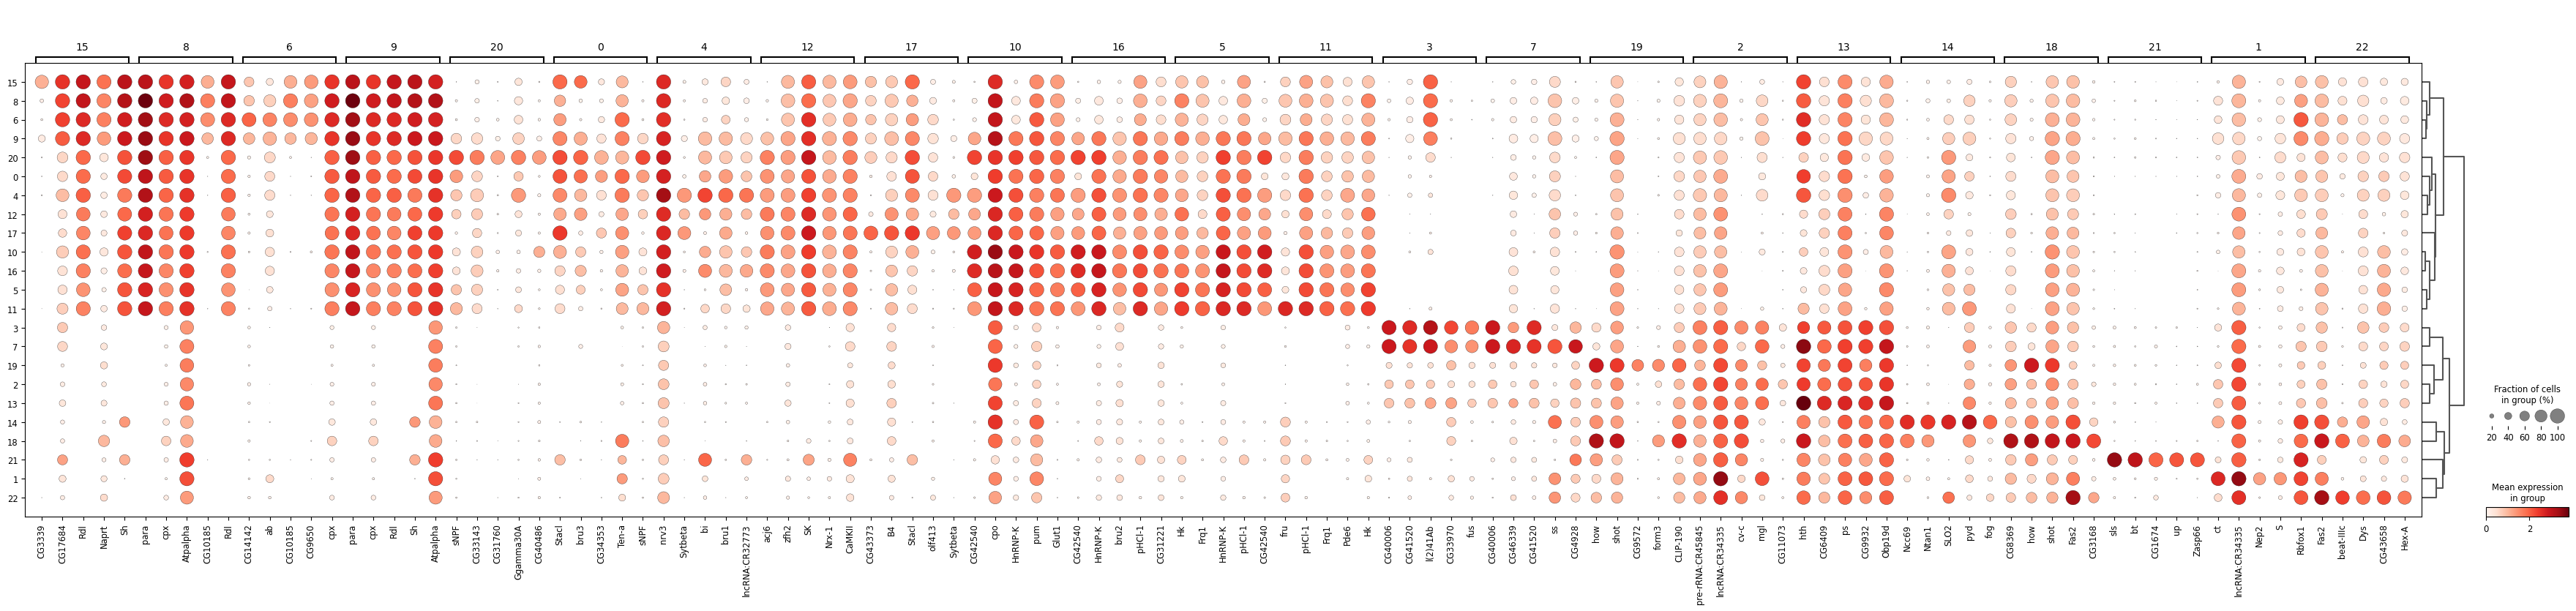

In [221]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',          # Cluster labels (e.g., 'leiden' or 'louvain')
    method='wilcoxon',         # Default: Wilcoxon rank-sum test
    key_added='rank_genes_groups'     # Key to store results in adata.uns
)
# Get top 5 markers per cluster
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')
top_markers = markers[markers.pvals_adj < 0.05].groupby('group').head(5)


sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden', n_genes=5)

Using annotations from ASAP we mapped the clusters to higher cell types.

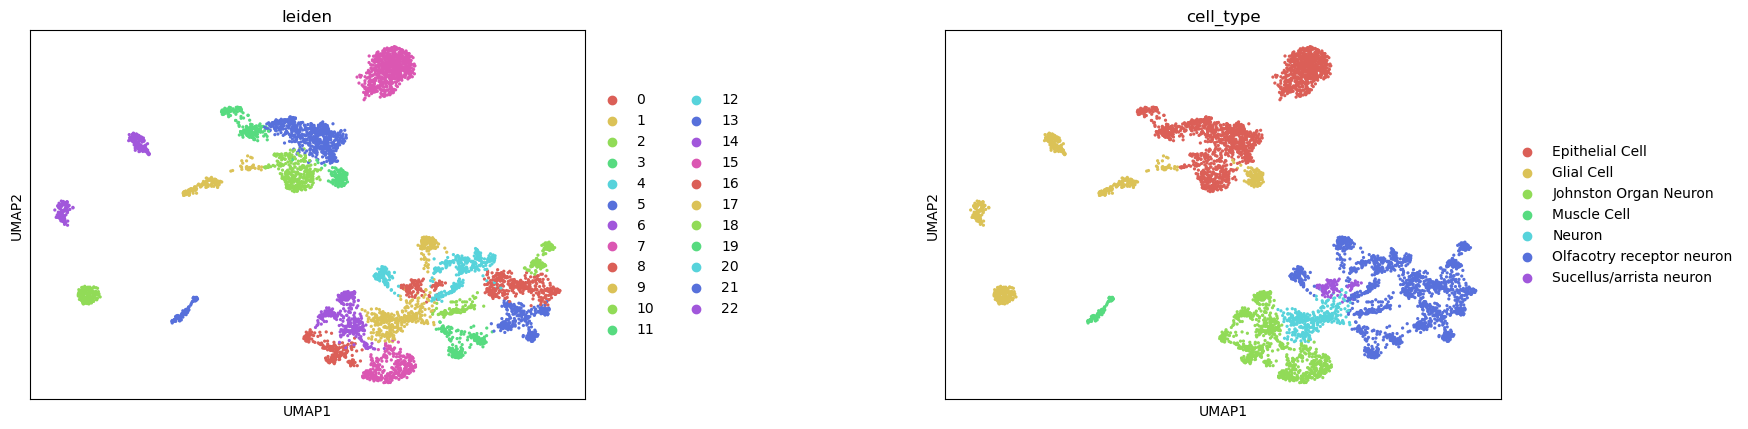

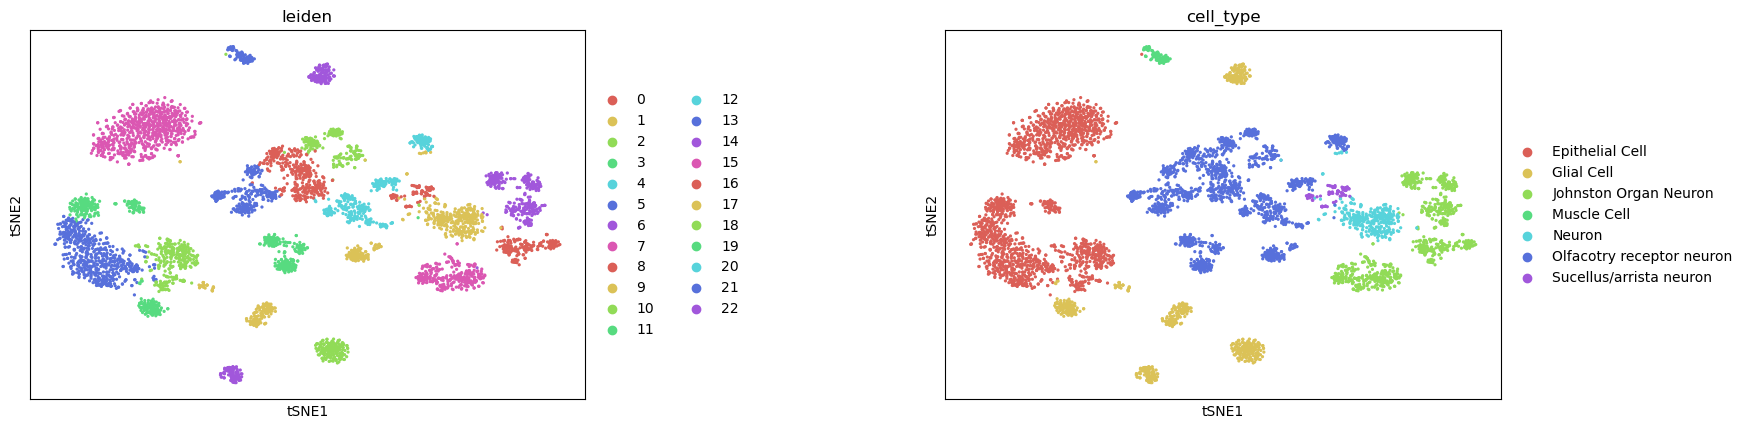

In [223]:
map={1:'Glial Cell',14:'Glial Cell',18:'Glial Cell', 19:'Glial Cell', 22:'Glial Cell',
   15:'Johnston Organ Neuron',8:'Johnston Organ Neuron',6:'Johnston Organ Neuron',
   13:'Epithelial Cell', 7:'Epithelial Cell', 3:'Epithelial Cell', 2:'Epithelial Cell',
   17:'Olfacotry receptor neuron',4:'Olfacotry receptor neuron', 10:'Olfacotry receptor neuron',
   9:'Olfacotry receptor neuron', 20:'Olfacotry receptor neuron', 12:'Olfacotry receptor neuron',
   11:'Olfacotry receptor neuron',  16:'Olfacotry receptor neuron', 5:'Olfacotry receptor neuron',
   9: 'Neuron', 0:'Sucellus/arrista neuron',
   21:'Muscle Cell'}
adata.obs['cell_type']=adata.obs['leiden'].astype(int).apply(lambda x: map[x] if x in map.keys() else x).astype("category")
sc.pl.umap(
    adata,
    color=['leiden','cell_type'],
    wspace=0.5,
    ncols=2,
    palette=sns.color_palette("hls", 8)
)
sc.pl.tsne(adata, color=['leiden', 'cell_type'],wspace=0.5)

The cell types can likely be broken down further but with this plot we capture the key cell types in the antennae. Using these cell types we can identify marker genes. 

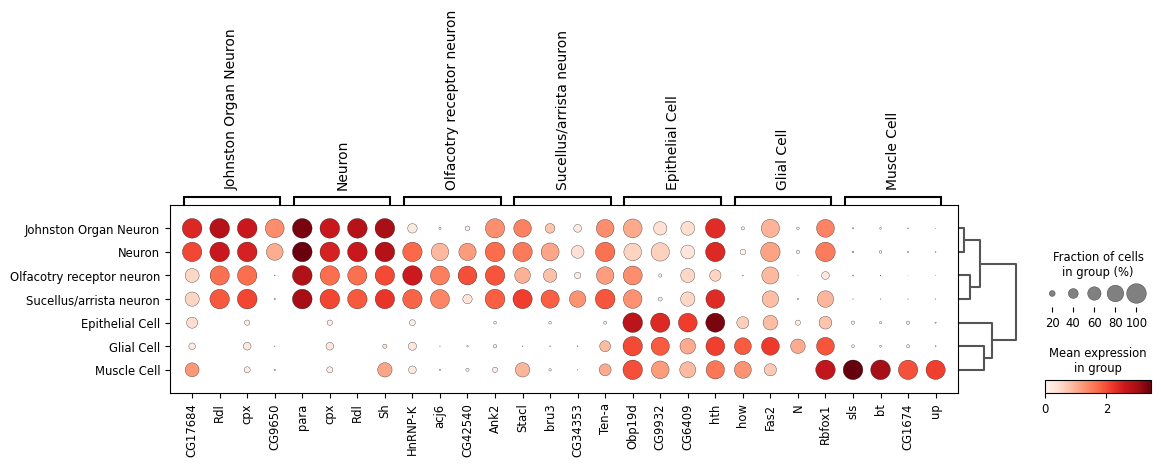

In [224]:
sc.tl.rank_genes_groups(
    adata,
    groupby='cell_type',          # Cluster labels (e.g., 'leiden' or 'louvain')
    method='wilcoxon',         # Default: Wilcoxon rank-sum test
    key_added='rank_genes_groups'     # Key to store results in adata.uns
)
# Get top 5 markers per cluster
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')
sc.tl.dendrogram(adata, groupby='cell_type')
sc.pl.rank_genes_groups_dotplot(adata, groupby='cell_type', n_genes=4)

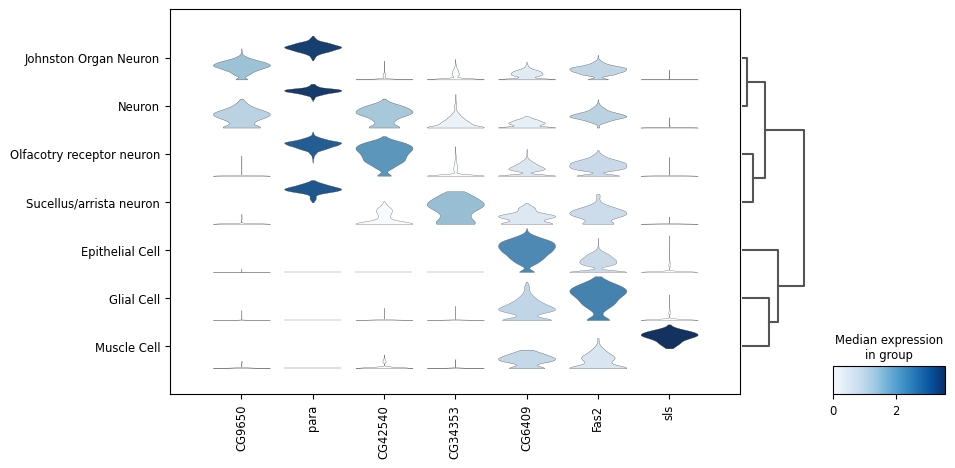

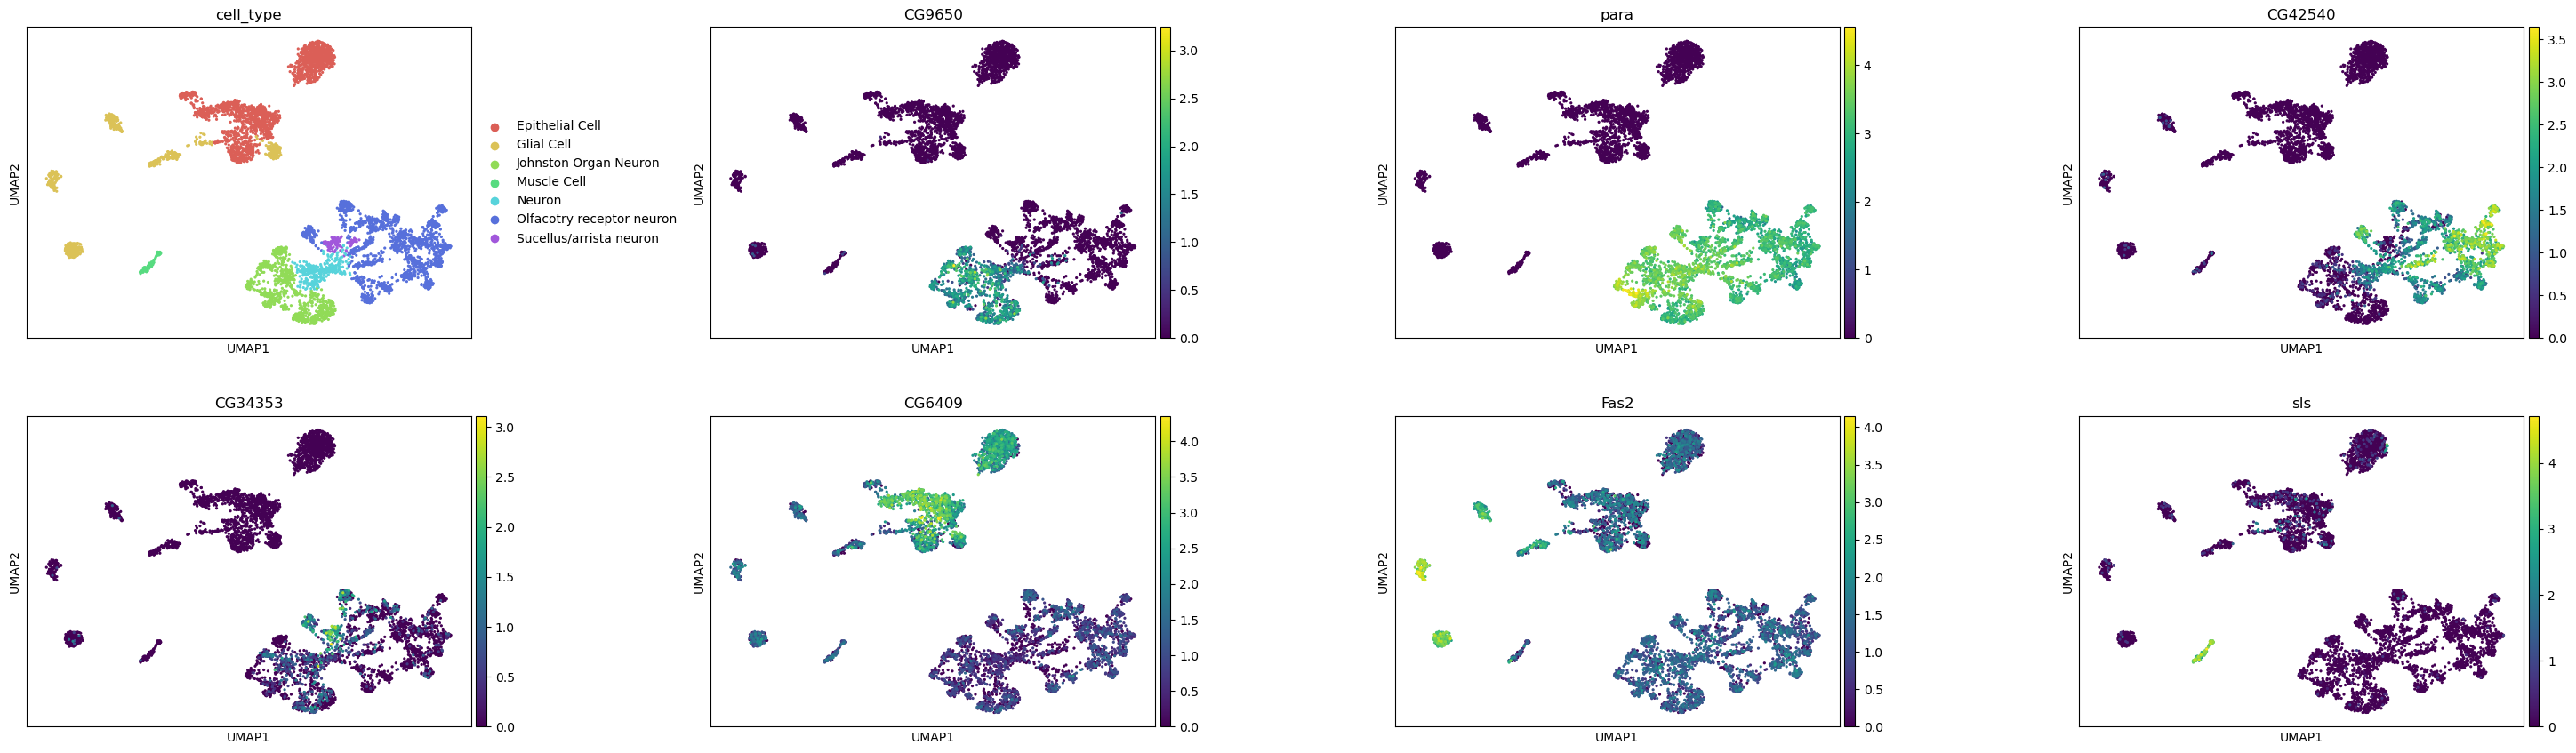

In [235]:
markers=['CG9650','para','CG42540','CG34353','CG6409','Fas2','sls']
sc.pl.stacked_violin(adata, markers, groupby='cell_type', dendrogram=True,figsize=(10,5))
sc.pl.umap(adata, color=['cell_type','CG9650','para','CG42540','CG34353','CG6409','Fas2','sls'],wspace=0.4)

The antenna is a complex sensory organ involved in detecting various environmental cues, such as chemical signals (olfaction), mechanical vibrations, and airflow. The cell types identified—**Epithelial Cell**, **Glial Cell**, **Johnston Organ Neuron**, **Muscle Cell**, **Neuron**, **Olfactory Receptor Neuron**, and **Scolopidium/Arista Neuron**—are expected in this tissue due to their roles in supporting its sensory and structural functions:

1. **Epithelial Cells**: These cells form the outer layer of the antenna, providing structural integrity and acting as a barrier to protect internal tissues.

2. **Glial Cells**: Essential for supporting neurons, glial cells maintain homeostasis, provide insulation, and aid in signal transmission within the nervous system of the antenna.

3. **Johnston Organ Neurons**: Located in the pedicel of the antenna, these neurons are mechanosensory and detect movement or vibrations, such as sound or wind.

4. **Muscle Cells**: These cells enable movement and positioning of the antenna, allowing it to orient toward stimuli.

5. **Neurons**: General neurons are expected as the antenna is a sensory organ, requiring neural circuits to process and transmit information to the brain.

6. **Olfactory Receptor Neurons**: These are specialized neurons that detect odor molecules, crucial for the antenna's role in olfaction.

7. **Scolopidium/Arista Neurons**: These are associated with the arista, a structure involved in detecting air currents or temperature changes, contributing to sensory perception.

In summary, the presence of these cell types reflects the antenna's multifunctional role in sensing and responding to environmental stimuli, combining structural, mechanical, and sensory capabilities.

# Marker Genes

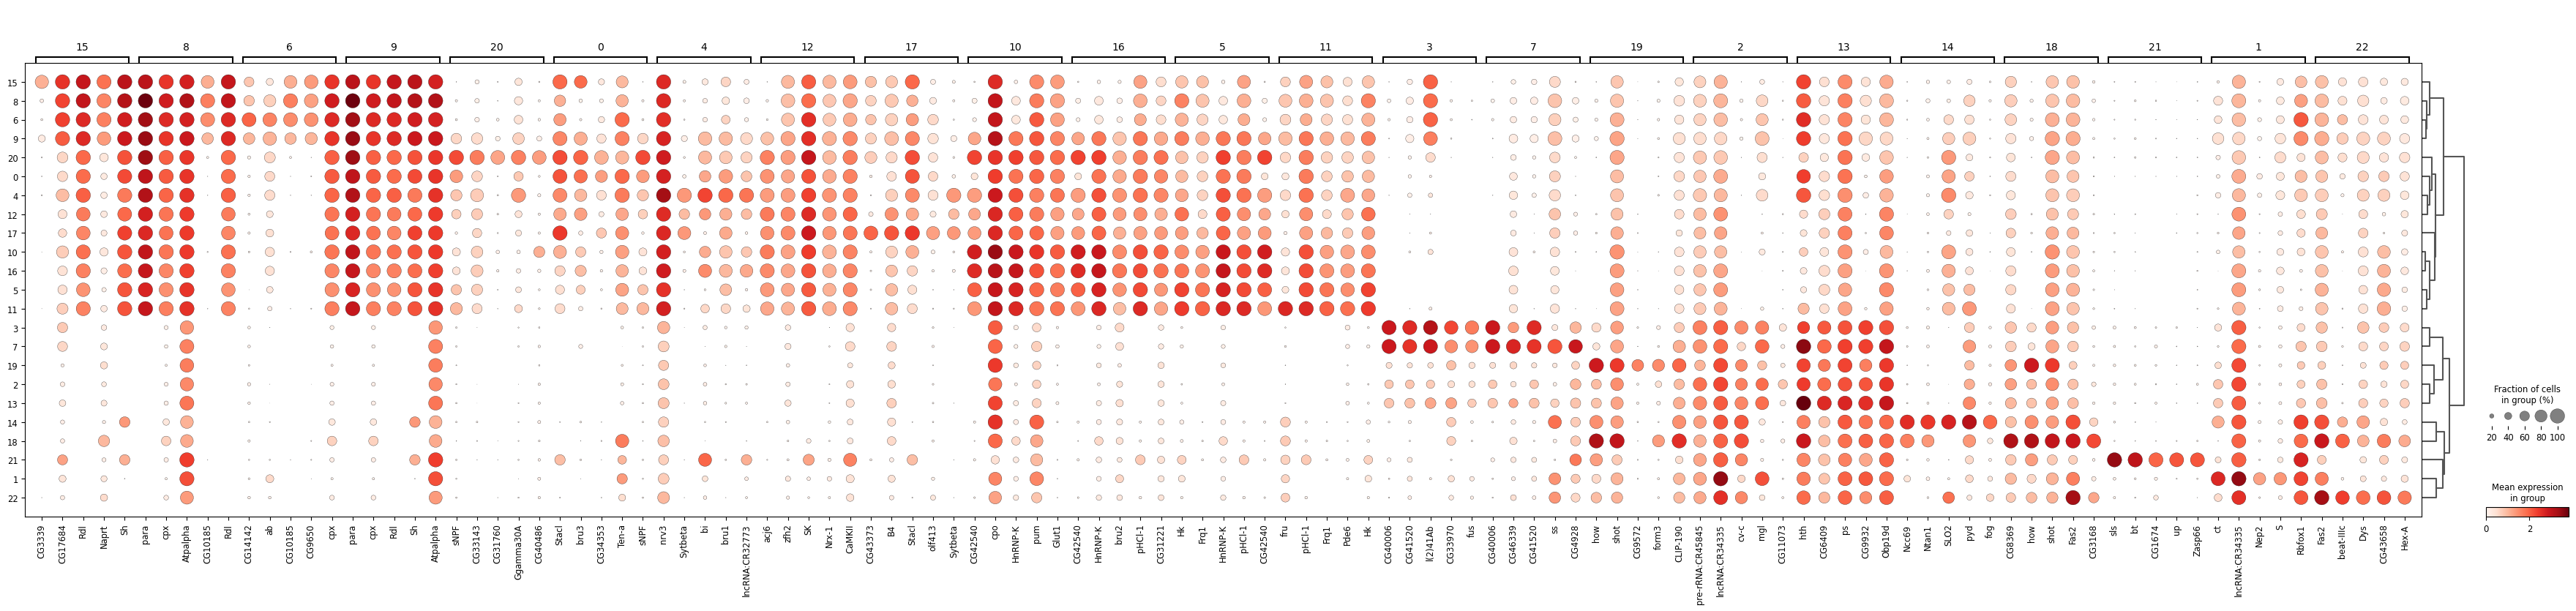

In [227]:
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',          # Cluster labels (e.g., 'leiden' or 'louvain')
    method='wilcoxon',         # Default: Wilcoxon rank-sum test
    key_added='rank_genes_groups'     # Key to store results in adata.uns
)
# Get top 5 markers per cluster
markers = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes_groups')
top_markers = markers[markers.pvals_adj < 0.05].groupby('group').head(5)


sc.tl.dendrogram(adata, groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata, groupby='leiden', n_genes=5)

para (0,4): Neuron 
CG3339 (1): Johnston organ neuron
Sytbeta (6): Olfactory receptor neuron
fru (8): Olfactory receptor neuron Or67d

bt, sls (11): muscle 

CG46339, ... (5): epithelial cells

repo ()
CG42235 (10): adult glial cells
Ncc69 (): adult glial cell
Fas2 (9, 12): adult glial cell
Nep2 (10): adult glial cell

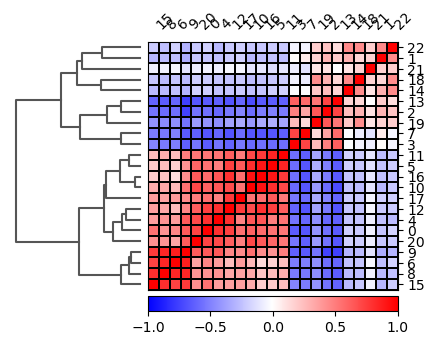

In [228]:
sc.pl.correlation_matrix(adata, "leiden", figsize=(5, 3.5))

#### Observed super-groups:
Using the dendrogram we can determine larger groups of cells that we can gather GO annotations for to perhaps determine their function.

Group 1: 15, 8, 6, 9

Group 2: 20, 0, 4, 12, 17, 10, 16, 5, 11 

Group 3: 3, 7, 19, 2, 13

Group 4: 21, 1, 22

Group 5: 14, 18

# GO Annotations (Pas ouf)

In [229]:
enriched_dfs = []
for group, names in top_markers.groupby('group')['names'].apply(lambda x: x.tolist()).to_dict().items():
    enriched_df = sc.queries.enrich(names, org='dmelanogaster')
    enriched_df['group'] = group  # Add the group as a column
    enriched_dfs.append(enriched_df)

# Step 2: Concatenate all the DataFrames
enriched_df = pd.concat(enriched_dfs, ignore_index=True)

# final_df now contains the concatenated DataFrame with the 'group' column

In [230]:
group_1  = [15, 8, 6, 9]
group_2= [20, 0, 4, 12, 17, 10, 16, 5, 11]
group_3= [3, 7, 19, 2, 13]
group_4= [21, 1, 22]
group_5=[14, 18]
print('group 1 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_1)]['name'].unique():
    print(name)
print('\n\ngroup 2 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_2)]['name'].unique():
    print(name)
print('\n\ngroup 3 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_3)]['name'].unique():
    print(name)
print('\n\ngroup 4 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_4)]['name'].unique():
    print(name)
print('\n\ngroup 5 GO annotations:')
for name in enriched_df[enriched_df['group'].astype(int).isin(group_5)]['name'].unique():
    print(name)

group 1 GO annotations:
negative regulation of secretion by cell
negative regulation of secretion
dme-let-7-5p
response to mechanical stimulus
membrane protein complex
transmembrane transporter complex
transporter complex
transmembrane transporter activity
transporter activity
inorganic molecular entity transmembrane transporter activity
monoatomic ion channel complex
monoatomic ion transmembrane transporter activity
chemical synaptic transmission
anterograde trans-synaptic signaling
trans-synaptic signaling
synaptic signaling
inorganic ion transmembrane transport
regulation of membrane potential
cell-cell signaling
plasma membrane protein complex
action potential
response to abiotic stimulus
monoatomic ion transmembrane transport
metal ion transmembrane transporter activity
gated channel activity
modulation of chemical synaptic transmission
regulation of trans-synaptic signaling
monoatomic ion transport
behavior
monoatomic ion channel activity
nervous system process
inorganic cation t

### **Group 1**  
**Key Terms and Definitions:**  
- **Ion transport/channel activity** (e.g., *voltage-gated ion channels*, *transmembrane transporter activity*): Proteins regulating ion flow across membranes, critical for electrical signaling.  
- **Synaptic signaling** (e.g., *chemical synaptic transmission*, *synaptic signaling*): Processes involved in neurotransmitter release and neuronal communication.  
- **Membrane protein complexes** (e.g., *plasma membrane protein complex*): Structures mediating cell signaling or transport.  
- **Regulation of membrane potential** and **action potential**: Electrical properties of excitable cells.  
- **Response to mechanical/abiotic stimuli**: Sensitivity to physical changes in the environment.  

**Hypothesis:**  
- These cells may be **neurons or electrically excitable cells** (e.g., neurons, neuroendocrine cells). They are likely involved in **synaptic transmission, ion homeostasis, and sensory processing**. There are terms that mention 'response to stimulus suggesting that this group may contain **sensory neurons**.
---

### **Group 2**  
**Key Terms and Definitions:**  
- **Neuronal compartments** (e.g., *neuronal cell body*, *axon*, *postsynaptic membrane*): Structural components of neurons.  
- **Trascription regulation** (e.g., *mRNA binding* and *calmodulin binding*, *Factor: Aef1*) Regulation of gene expression and calcium signaling.  
- **G protein-coupled receptor (GPCR) signaling**: Cell communication via receptors linked to intracellular pathways.  
- **Small conductance calcium-activated potassium channels**: Modulate neuronal excitability.  

**Hypothesized Function/Cell Type:**  
- **Neuronal subtypes with regulatory roles** (e.g., **motor neurons**, **interneurons**, or **secretory neurons**).  
- Functions may include **maintaining cell size**, **calcium-dependent signaling**, and **axonal transport**.  
- The presence of **apolipoprotein binding** hints at lipid metabolism involvement, possibly **glia-neuron interactions** (e.g., astrocytes supporting neurons).  

---

### **Group 3**  
**Key Terms and Definitions:**  
- **Cytoskeletal organization** (e.g., *actin binding*, *microtubule plus-end*): Dynamic cytoskeletal remodeling.  
- **Growth cone** and **axonal growth cone**: Structures guiding axon extension during development.  
- **Muscle attachment** and **hemidesmosome**: Cell-matrix adhesion structures.  
- **Branch/tube fusion**: Developmental processes (e.g., tracheal system in *Drosophila*). 

**Hypothesis:** 
- **Developing or regenerating neurons** (e.g., **axonal growth cones** during neurite outgrowth).  
- Alternatively, **muscle-associated cells** (e.g., **myocytes** or **tendon cells**) involved in cytoskeletal organization and adhesion.  
- May also include **glial cells** supporting axon guidance (e.g., **Schwann cells**).  

---

### **Group 4**  
**Key Terms and Definitions:**  
- **Morphogenesis** (e.g., *wing morphogenesis*, *appendage development*): Tissue/organ shape formation.  
- **Muscle development** (e.g., *sarcomere*, *myofibril*, *actin cytoskeleton*): Muscle structure assembly.  
- **Cardiac terms** (e.g., *cardiac fibrosis*, *ventricular hypertrophy*): Pathological or developmental heart processes. Does not seem to be relevant as our data is from the antennae.
- **Membraneless organelles** (e.g., *stress granules*): Dynamic cellular compartments.  

**Hypothesis:** 
- **Muscle cells** involved in **contraction** and **structural organization**.  
- Terms like *Malpighian tubule morphogenesis* and *wing disc morphogenesis* suggest **developmental patterning** (possibly *Drosophila* or insect model data).  
- May include **fibroblasts** (e.g., *cardiac fibrosis*) or **progenitor cells** driving tissue remodeling.  
- The mix of **muscle** and **morphogenesis** terms implies roles in **embryonic development** or **tissue repair**.  

---

### **Group 5**  
**Key Terms**:  
- **Potassium ion transport** (intracellular sodium-activated potassium channels).  
- **Growth cone** and **muscle attachment** (shared with Group 3).  
- **Aortopulmonary collateral arteries** and **virion interactions** (Ebolavirus/Lyssavirus).  
- **Aortopulmonary collateral arteries** are abnormal vessels in congenital heart defects.  
- **Virion terms** suggest viral entry/replication mechanisms.  

**Hypothesized Function**:  
- **Mixed identity**: Potentially **vascular smooth muscle cells** (aortopulmonary arteries) or **neuronal-muscle hybrid cells**.  
- **Potassium channels** are critical in both excitable cells (neurons) and vascular tone regulation.  
- **Viral terms** could indicate infection susceptibility (e.g., endothelial cells targeted by Ebola virus).  
- May represent **artifact** or contamination (e.g., viral RNA in sequencing data).  
---

### **Summary of Hypotheses:**  
1. **Group 1**: **Neurons** (sensory/interneurons) involved in synaptic signaling and ion transport.  
2. **Group 2**: **Neuronal subtypes** regulating calcium signaling and mRNA processing.  
3. **Group 3**: **Developing neurons** or **muscle-associated cells** with cytoskeletal remodeling roles.
4. **Group 4**: **Muscle/cardiac cells** or **developmental progenitors** driving morphogenesis and contractility.  
5. **Group 5**: Vascular/neuronal-muscle hybrids or artifact (requires validation).  
---

### **Caveats and Next Steps:**  
- **Validate with markers**: Confirm hypotheses using known markers (e.g., *Tubb3* for neurons, *Myh6* for cardiac muscle).  
- **Check species context**: Terms like *Malpighian tubule* or *wing disc* suggest insect data (e.g., *Drosophila*). Adjust hypotheses if working with non-model organisms.  
- **Functional assays**: Test electrophysiology (Group 1), calcium imaging (Group 2), or contractility (Group 4) to confirm roles.  
- **Resolve overlaps**: Some terms (e.g., *muscle attachment*) appear in multiple groups—explore if these represent distinct subtypes or shared processes.  